# Computer Vision & Deep Learning - SEP Practical

## Exercise Sheet 4: Data Visualization, k-NN Classification, Intro to PyTorch

**Due on 07.12.2023, 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!



In [1]:
import time
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets

---
## 1. Data Visualization (10)

Before we can train a Neural Network, we usually need to prepare the data for training and testing. When working with a new data it is important to first look at its basic characteristics. One popular tool for this task is the Principal Component Analysis (PCA). You might already be familiar with PCA. If not, you can get an overview [here](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c). In the case of high dimensional image data (e.g. a tiny $28 \times 28$ pixel image is already $784$-dimensional, when reshaped to a vector) the PCA identifies the directions with the highest variance (i.e. principal components) in this high dimensional space. The idea is simple: The principal components of our data (e.g. 784-dimensional vectors), along which the position of individual data points (e.g. image vectors) varies the most, are likely to be the most informative part of our data.

In this task you will work with images from the popular MNIST dataset, prepare the training and the test sets, visualize their largest principal components and use those to plot a two dimensional distribution of the images.


### 1.1 Data Statistics (2)

Using the function `load_data`, load the train split of MNIST and plot 10 examples of digits with their label as title. Also report the following statistics about the train set: `min`, `max`, `mean`, `shape`, `dtype`. Here, you can imagine the train set as a large data array and report the statistics on that array.

In [2]:
def load_data(train=True, save_dir="data"):
    mnist_ = datasets.MNIST(save_dir, train=train, download=True)
    data_, labels_ = mnist_.data.numpy(), mnist_.targets.numpy()
    return data_, labels_

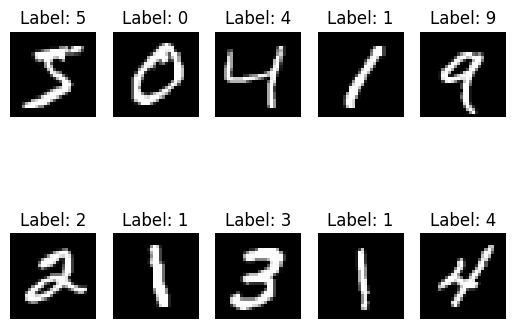

Min   : 0
Max   : 255
Mean  : 33.3184
Std   : 78.5675
Shape : (60000, 28, 28)
Dtype : uint8


In [3]:
# TODO
images, labels = load_data(train=True)

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

print(f"{'Min':<6}: {images.min()}")
print(f"{'Max':<6}: {images.max()}")
print(f"{'Mean':<6}: {images.mean():.4f}")
print(f"{'Std':<6}: {images.std():.4f}")
print(f"{'Shape':<6}: {images.shape}")
print(f"{'Dtype':<6}: {images.dtype}")

### 1.2 Convert to vectors (2)

Convert all images into plain vectors and process them to be in the range $[-1, 1]$. In the end you should have two `numpy` arrays of images and labels. Please print the shape of both, vectorized images and labels, and also the `min`, `max`, and `mean` of the processed images.

In [4]:
# TODO: Convert the ``[28, 28]`` MNIST images to vectors of
# size ``[28*28]``,  s.t. the data has the shape of ``[N, 784]``,
# where ``N`` is the number of images.

# slow version
t0 = time.time()
vec_images = []
for image in images:
    normalized_image = image / 255.
    normalized_image = normalized_image * 2 - 1
    vec_images.append(normalized_image.flatten())
vec_images = np.array(vec_images)
print(f"{'Slow':<6}: {time.time() - t0:.4f}s")

# efficient version
t0 = time.time()
vec_images = images / 127.5 - 1
vec_images = vec_images.reshape(-1, 28*28)
print(f"{'Fast':<6}: {time.time() - t0:.4f}s")

print(f"{'Data':<6}: {vec_images.shape}")
print(f"{'Min':<6}: {vec_images.min()}")
print(f"{'Mean':<6}: {vec_images.mean():.4f}")
print(f"{'Max':<6}: {vec_images.max()}")
print(f"{'Labels':<6}: {labels.shape}")


Slow  : 0.3850s
Fast  : 0.0899s
Data  : (60000, 784)
Min   : -1.0
Mean  : -0.7387
Max   : 1.0
Labels: (60000,)


### 1.3 PCA (3)

Now run the provided `do_pca` function on the converted data in order to obtain a matrix of sorted eigenvectors that represent the principal components of the train set. Reshape the 10 most important principal components to the shape of [28, 28] in order to plot them as images.

Explain what you are seeing. Can you make a statement regarding the difficulty of MNIST digit classification problem? What would you expect the principal components to look like, if the problem was easy?

In [5]:
def do_pca(vectors):
    """
    Returns matrix [784 x 784] whose columns are the sorted eigenvectors.
    Eigenvectors (prinicipal components) are sorted according to their
    eigenvalues in decreasing order.
    """
    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    return sorted_eigenVectors.astype(np.float32).T

Eigenvectors: (784, 784)


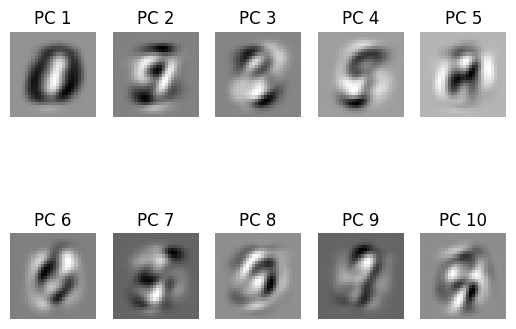

In [6]:
sorted_ev = do_pca(vec_images)
print(f"Eigenvectors: {sorted_ev.shape}")

first_pcs = sorted_ev[:10].reshape(-1, 28, 28)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(f"PC {i+1}")
    plt.imshow(first_pcs[i], cmap='gray')
    plt.axis('off')
plt.show()

### 1.4 Projection (3)

Project the MNIST vectors of the train set onto the two most important principal components (associated with two largest eigenvalues). Use the dot product for the projection into the 2D feature space spanned by the two principal components and plot the resulting points in a scatter plot (use the `scatter` provided by matplotlib for this). To get a better overview you can also choose a subset of the points. Color each dot corresponding to its class.

Interpret the plot. What can it tell us about the MNIST dataset? Can you make a statement regarding the difficulty of MNIST digit classification problem?

First two PCs: (2, 784)
Vectorized images: (60000, 784)


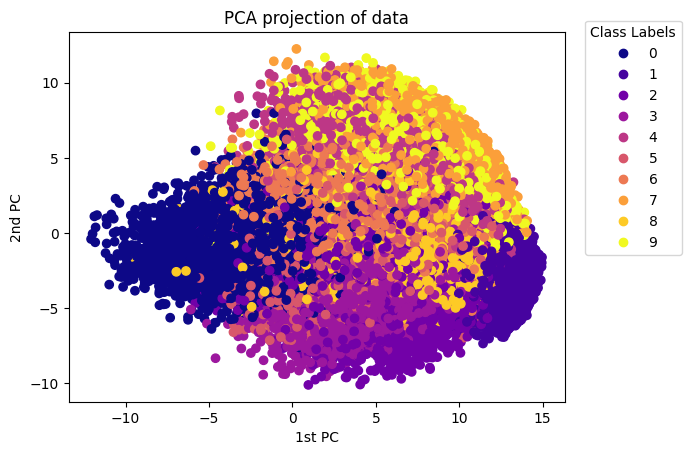

In [7]:
# TODO: Projects ``data`` onto the first two ``sorted_eigenVectors`` and
# make a scatterplot of the resulting points

first_two = sorted_ev[:2]
print(f"First two PCs: {first_two.shape}")
print(f"Vectorized images: {vec_images.shape}")
projected_data = np.dot(vec_images, first_two.T)

fig, ax = plt.subplots()
scatter = ax.scatter(projected_data[:,0],projected_data[:,1],c=labels, cmap='plasma')

ax.set_title('PCA projection of data')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.legend(*scatter.legend_elements(),
            title='Class Labels',
            loc='upper right',
            bbox_to_anchor=(1.25, 1.05))
    
plt.show()

---
## 2. k-NN Classification (20)

In this exercise, we will explore one of the simplest yet effective algorithms in machine learning. 
We will implement a KNN classifier with an interface similar to that provided by `sklearn.neighbors.KNeighborsClassifier`.

In [8]:
import sklearn.datasets
import sklearn.neighbors

In [9]:
# Data
n = 1000
n_train = 900
n_test = n - n_train
x, y = sklearn.datasets.make_moons(n_samples=n, noise=0.2, random_state=0)
xtrain, ytrain = x[:n_train, ...], y[:n_train, ...]
xtest, ytest = x[n_train:, ...], y[n_train:, ...]

### 2.1: Visualization (1)
Visualize the previous generated dataset $x$ according to their label $y$ using matplotlib.

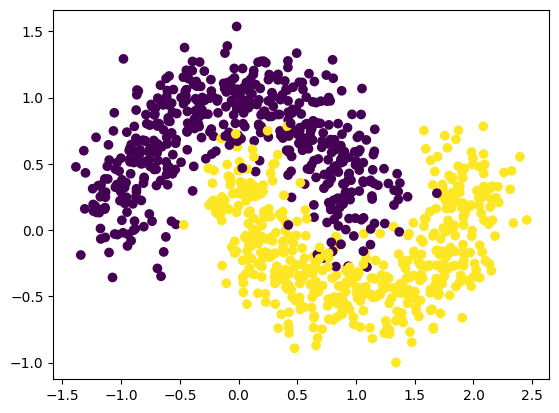

In [10]:
# TODO
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

### 2.2: Implement the KNN algorithm (5)

First, implement the `kneighbors` method of the KNN class. For given query points, it should return the indices of the k-nearest neighbors in the training set, where k is given by KNN.n_neighbors, together with the distances. Use the euclidean metric for distances. You should only use numpy in your im- plementation and please make sure that your implementation is vectorized.

Also implement the `predict` method of the KNN class, which should return the predicted label of each query point.

In [11]:
class KNN(object):
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, x, y):
        self.x = x
        self.y = y

    def kneighbors(self, xquery):
        # TODO return indices of nearest neighbor points and distances to them
        xtrain = self.x[None, :, ...]
        xquery = xquery[:, None, ...]
        D = np.sqrt(np.sum((xtrain - xquery) ** 2, axis=2))
        nns = np.argsort(D, axis=1)
        nnD = np.take_along_axis(D, nns, axis=1)

        return nns[:, : self.n_neighbors], nnD[:, : self.n_neighbors]

    def predict(self, xquery):
        # TODO return predicted label for each query point
        nns, nnD = self.kneighbors(xquery)
        ys = np.take(self.y, nns)

        def most_common(row):
            vals, freqs = np.unique(row, return_counts=True)
            return vals[freqs.argmax()]

        ys = np.apply_along_axis(most_common, axis=1, arr=ys)
        return ys

### 2.3: Validate your results against `sklearn.neighbors.KNeighborsClassifier` (3)

For $k=5$, fit both your kNN implementation and that from sklearn to the training data and check that their predictions on the test set are the same.

In [12]:
# TODO
k = 5
sknn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
sknn.fit(xtrain, ytrain)
sknn_y = sknn.predict(xtest)

knn = KNN(n_neighbors=k)
knn.fit(xtrain, ytrain)
knn_y = knn.predict(xtest)

assert (sknn_y == knn_y).all()

### 2.4: Evaluate and visualize for different $k$ (5)

Evaluate and plot the accuracy of the KNN classifier on the test set against different values of $k$.

For each $k$, plot the decision boundary of the kNN classifier with the test data points on top. Plot the decision boundary within the box $[−1.5,2.5]\times[−1.0,1.5]$.

***Hint***: For plotting the decision boundary, evaluate the kNN classifier on a grid within this box. Use 100 points in each direction for this grid, which can be achieved with `numpy.meshgrid`. Use the results to draw a filled contour plot (`matplotlib.pyplot.contourf`).


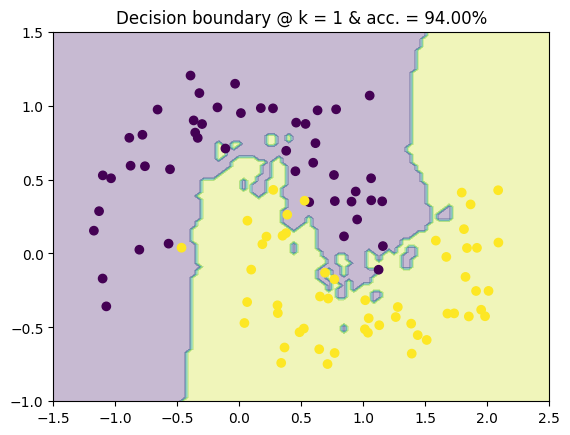

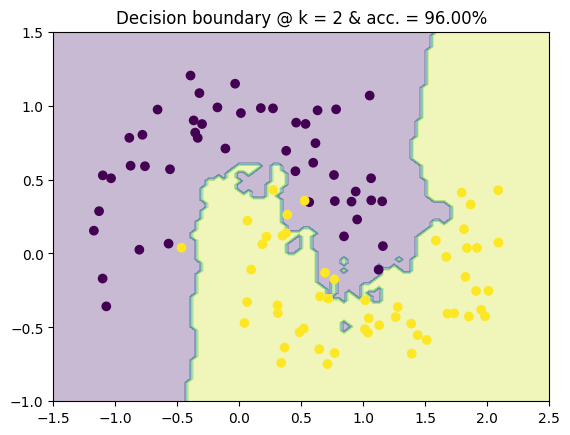

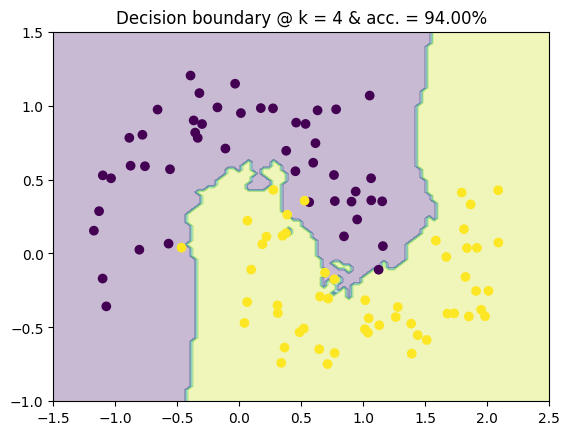

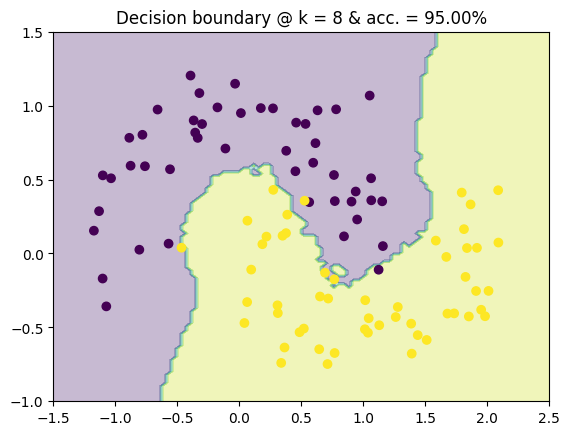

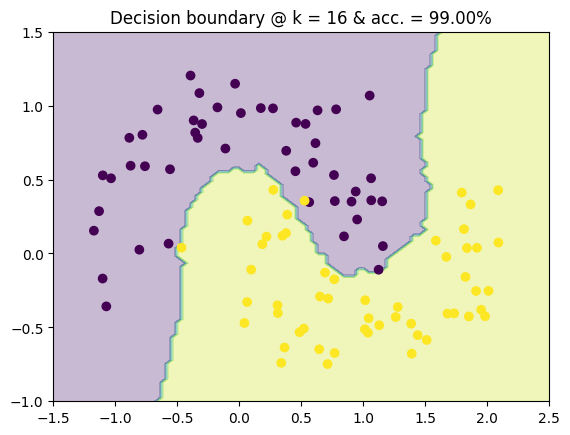

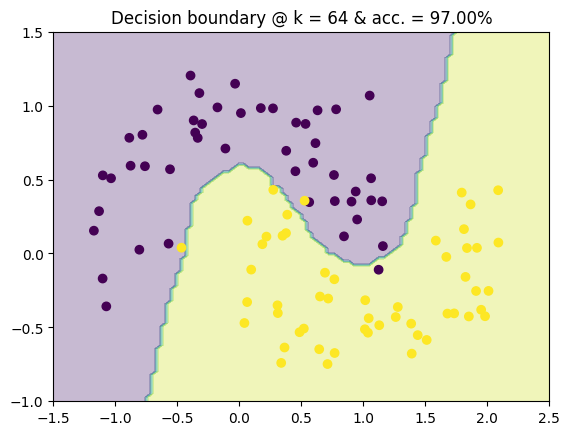

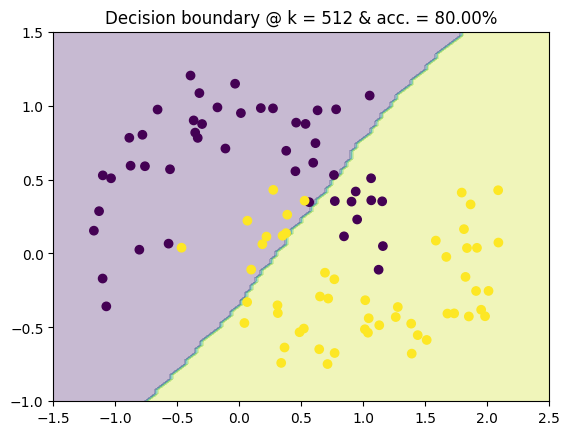

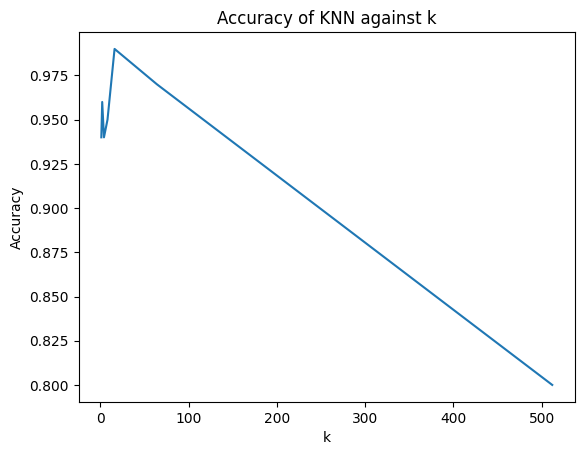

In [13]:
ks = [1,2,4,8,16,64,512]
accs = list()
for k in ks:
    # TODO fit and evaluate accuracy on test data
    knn = KNN(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    knn_y = knn.predict(xtest)
    acc = np.mean(knn_y == ytest)
    accs.append(acc)

    # TODO plot decision boundary
    N = 100
    x = np.linspace(-1.5, 2.5, N)
    y = np.linspace(-1.0, 1.5, N)
    XX, YY = np.meshgrid(x, y)
    XY = np.stack([XX, YY], axis=2)
    XY = XY.reshape(-1, 2)
    y_XY = knn.predict(XY).reshape(XX.shape)

    # fig, axes = plt.subplots(
    #     1, 1, figsize=[12.8, 7.2], dpi=100, constrained_layout=True
    # )
    # axes.contourf(XX, YY, y_XY, alpha=0.3)
    # axes.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
    plt.contourf(XX, YY, y_XY, alpha=0.3)
    plt.title(
        "Decision boundary @ k = {} & acc. = {:.2f}%".format(k, 100 * acc)
    )
    plt.scatter(xtest[:, 0], xtest[:, 1], c=ytest)
    plt.show()

# TODO plot accuracy against k
plt.plot(ks, accs)
plt.title("Accuracy of KNN against k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

### 2.5 Impact of $k$ (1)

What is the effect of $k$ on the decision boundary? What would happen in the case where $k$ equals the number of training examples?

As $k$ increases, the model becomes less sensitive to individual data points. As a result, the decision boundaries are smoothed out. 

If $k$ equal the number of training samples then the KNN classification would do the classification agnostic to the test data samples since they all share the same nearest neighbors.

### 2.6 Apply KNN to real images (5)

In this exercise, we will apply KNN classification to image data. Use the images from the MNIST dataset with labels between 0 and 9. You can either use your own KNN implementation from the previous task or that of sklearn. 

Evaluate and plot the accuracy of the kNN classifier on the test set against different values of $k = 2^i, i = 0,...,3$. Afterwards, produce 10 test images together with their k-nearest neighbors.

In [14]:
# Data
data = sklearn.datasets.load_digits()
x, y = (data.images / 16.0).reshape(-1, 8 * 8), data.target
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
    x, y, test_size=0.25, shuffle=True, random_state=0
)

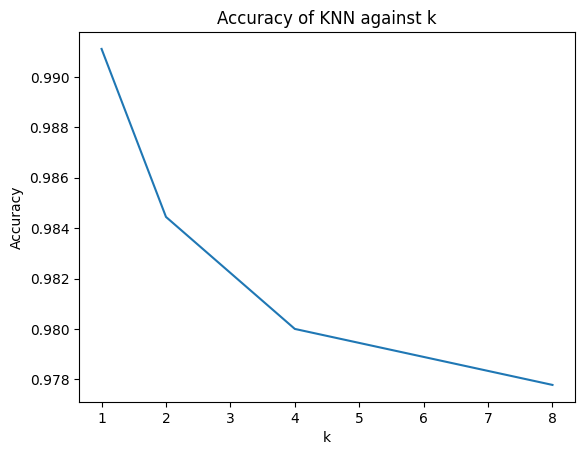

In [15]:
# TODO analyze accuracy for different values of k
ks = [2 ** i for i in range(4)]
accs = list()
for k in ks:
    knn = KNN(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    knn_y = knn.predict(xtest)
    acc = np.mean(knn_y == ytest)
    accs.append(acc)

plt.plot(ks, accs)
plt.title("Accuracy of KNN against k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

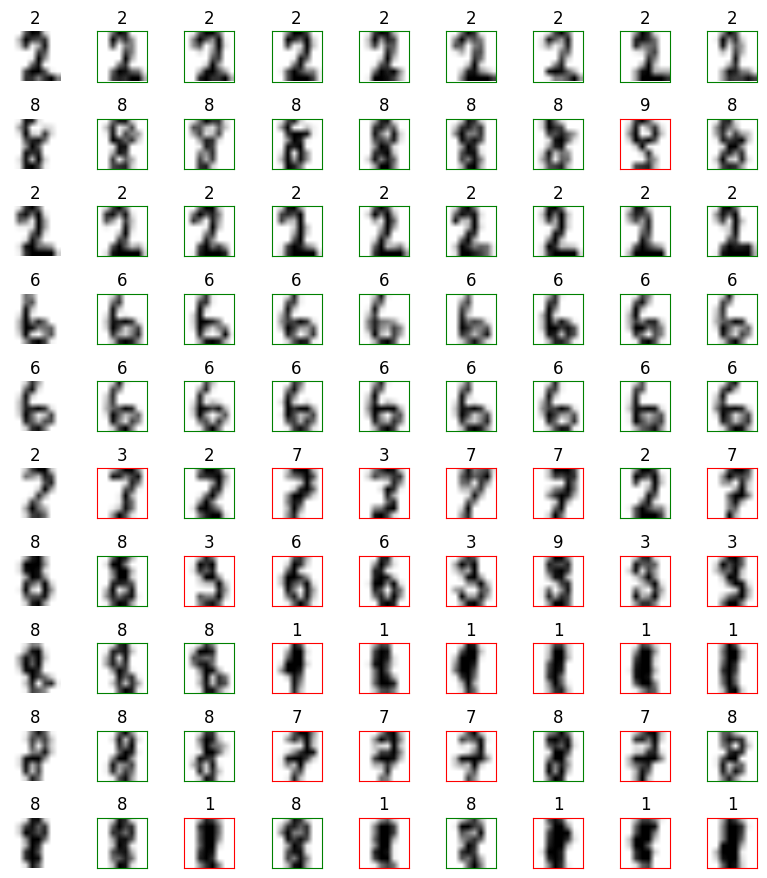

In [16]:
rows = 10
cols = k + 1
w = 8.0
fig, axes = plt.subplots(
    rows, cols, figsize=[w, w*rows/cols], dpi=100, tight_layout=True
)
correct = np.where(knn_y == ytest)[0][:5]
wrong = np.where(knn_y != ytest)[0][:5]
query_indices = np.concatenate([correct, wrong])
xquery = xtest[query_indices, ...]
xnn_ind, _ = knn.kneighbors(xquery)
for i in range(rows):
    query_label = ytest[query_indices[i]]
    for j in range(cols):
        nn_label = ytrain[xnn_ind[i, j - 1]]
        if j == 0:
            xshow = xquery[i]
            xlabel = query_label
        else:
            xshow = xtrain[xnn_ind[i, j - 1], ...]
            xlabel = nn_label
        axes[i, j].imshow(
            xshow.reshape(8, 8), cmap=plt.cm.gray_r, interpolation="bilinear"
        )
        axes[i, j].set_title(str(xlabel))
        if j == 0:
            axes[i, j].set_axis_off()
        else:
            color = "green" if query_label == nn_label else "red"
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            for s in axes[i, j].spines.values():
                s.set_color(color)
plt.show()

---
## 3. Introduction to PyTorch (10)

To start with, install `PyTorch` on your machine. You will learn how to operate with Tensors and also re-implement the Gaussian blurring and convolution operation using PyTorch.

### 3.1 PyTorch basic operation (2)

Please inspect the [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial) if you are relatively new to PyTorch. Load the image `munich.jpg` with the following operations:

- Load the image using `Pillow` and `NumPy`
- Convert it to a `PyTorch`` Tensor, notice how the format is still [H, W, C]
- Swap the axes such that the format is [C, H, W]
- Now swap the axes back to format [H, W, C]
- Convert the PyTorch tensor back to a NumPy array
- Save the image and make sure it still looks the same

Original image:


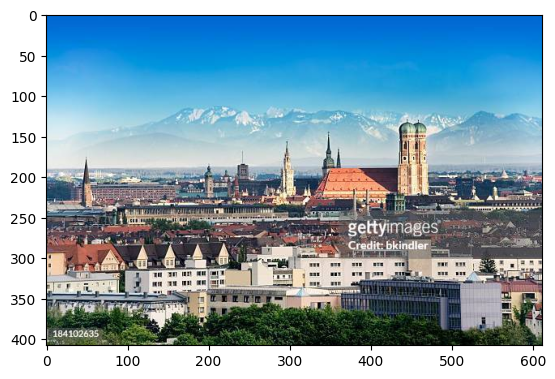

Image after transformation:


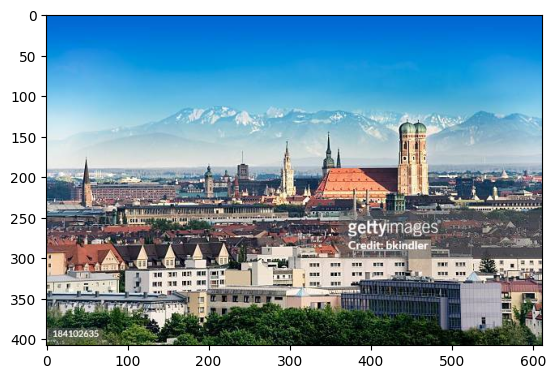

In [17]:
array = Image.open('munich.jpg')
im = np.array(array)
im = torch.from_numpy(im).float() / 255.
im = im.permute(2, 1, 0)

# reverse
im = im.permute(2, 1, 0)
array_back = im.numpy()

print('Original image:')
plt.imshow(array)
plt.show()
print('Image after transformation:')
plt.imshow(array_back)
plt.show()

### 3.2 PyTorch Conv2d (1)

Implement a Conv2d layer with `torch.nn.Conv2d`, which takes 1 in-channel. 1 out-channel, a kernel size of 5, and a stride of 2 without bias. Please print the shape of the layer weight.

***Hint***: PyTorch will initialize the weights randomly, you can access them with `.weight`. The shape of `conv.weight` will be (i, o, h, w), where the first dimension is the number of kernels that will be applied to the image, the second dimension is the number of image channels, and the last two dimensions represent the kernel size.

In [18]:
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=2, padding=0, bias=False)
print(conv.weight.shape)

torch.Size([1, 1, 5, 5])


### 3.3 Loading kernel into Conv2d (2)

Recall the exercise where we implemented a Gaussian kernel in NumPy. Transform a Gaussian kernel of size 5 and variance 8 into a torch Tensor. Make sure you transform it so that it actually matches the convolutional kernel weights and replace the Conv2d weights with the Gaussian kernel weights. The Numpy Gaussian kernel is already implemented for you.

In [19]:
# Defining the Gaussian filter

def gaussian_filter(size: int, var: float):
    # if size is not odd number, the resulting kernel shifts the image
    grid_range = np.linspace(-np.floor((size-1)/2), np.ceil((size-1)/2), size)
    x, y = np.meshgrid(grid_range, grid_range)
    kernel = 1./(2*np.pi*var) * np.exp(-1./(2*var)*(np.square(x)+np.square(y)))
    # normalize the filter
    kernel = kernel / np.sum(kernel)
    return kernel

# TODO
kernel = torch.from_numpy(gaussian_filter(5, 8)).float().unsqueeze(0).unsqueeze(0)
conv.weight = torch.nn.Parameter(kernel)

### 3.4 Perform Convolution (2)

Now you should be able to carry out convolution with our predefined kernel. As we defined a kernel that takes one input channel, we first need to turn the color image into black and white by averaging over all RGB channels. Note that the Conv2D takes an image input of `[C, H, W]` or `[B, C, H, W]`. Make sure that the image is within range [0, 1] before you apply the kernel.

Visualize the black and white image and the results after convolution. What do you see?

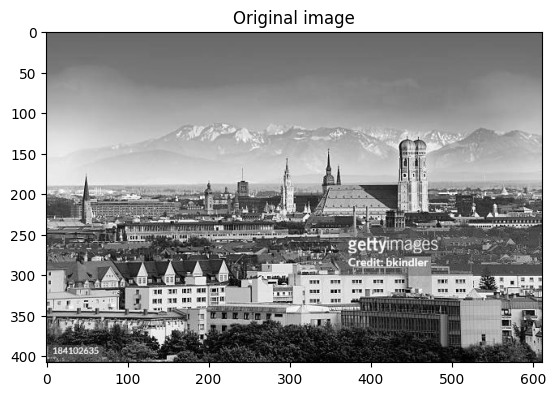

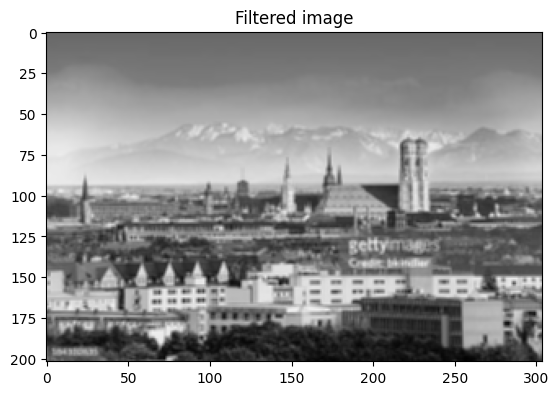

In [20]:
array = Image.open('munich.jpg')
im = np.array(array)
im = torch.from_numpy(im).float() / 255.

im_chw = im.permute(2, 0, 1).mean(dim=0, keepdim=True)
plt.imshow(im_chw.permute(1, 2, 0).repeat(1,1,3).detach().numpy())
plt.title('Original image')
plt.show()
plt.imshow(conv(im_chw).permute(1, 2, 0).repeat(1,1,3).detach().numpy())
plt.title('Filtered image')
plt.show()

### 3.5 Kernel Variance (1.5)

Please also visualize the convolved image for a Gaussian kernel with size 5 and variance 1 and 30. What do you observe?

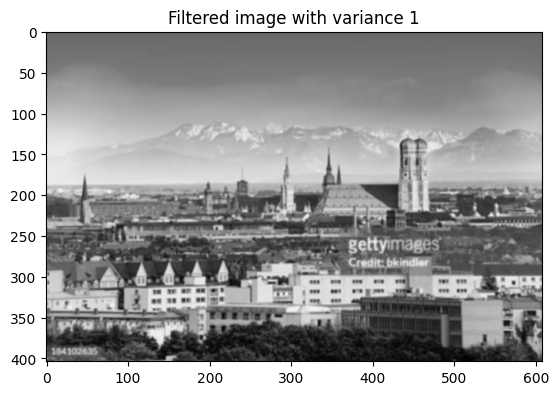

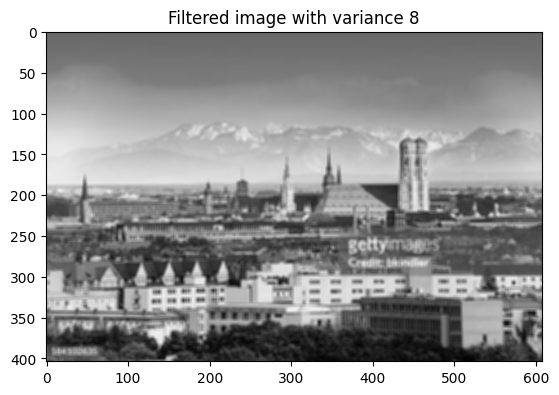

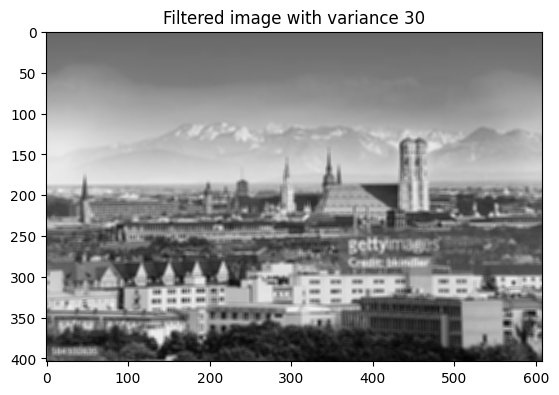

In [21]:
array = Image.open('munich.jpg')
im = np.array(array)
im = torch.from_numpy(im).float() / 255.

variances = [1, 8, 30]

for variance in variances:
    conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=0, bias=False)
    kernel = torch.from_numpy(gaussian_filter(5, variance)).float().unsqueeze(0).unsqueeze(0)
    conv.weight = torch.nn.Parameter(kernel)
    im_chw = im.permute(2, 0, 1).mean(dim=0, keepdim=True)
    
    plt.imshow(conv(im_chw).permute(1, 2, 0).repeat(1,1,3).detach().numpy())
    plt.title(f'Filtered image with variance {variance}')
    plt.show()

### 3.6 Kernel Size (1.5)
Thereafter fix the variance to 8 and also visualize the results for kernel size 3, 7, and 15. Describe the effect of different kernel sizes.

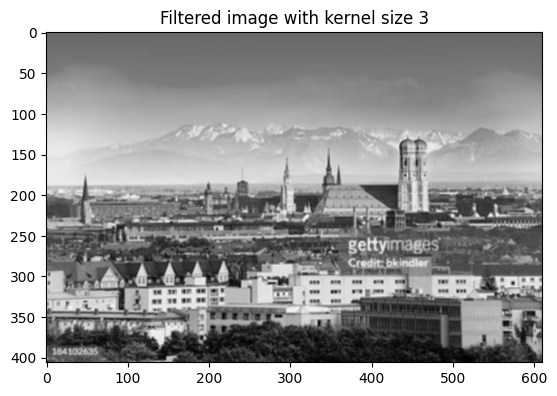

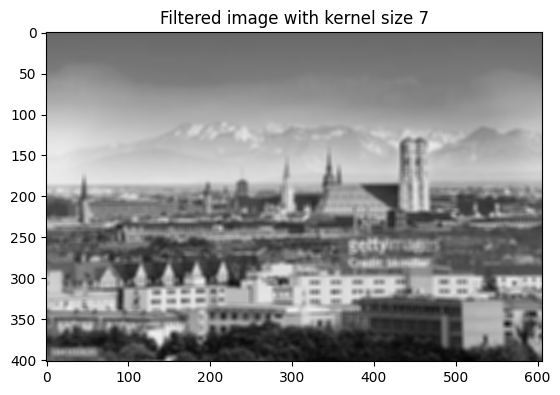

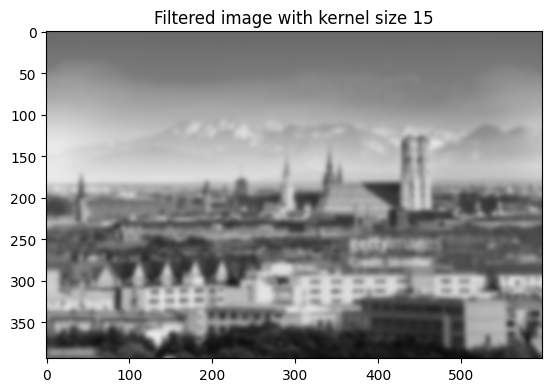

In [22]:
array = Image.open('munich.jpg')
im = np.array(array)
im = torch.from_numpy(im).float() / 255.

kernel_sizes = [3, 7, 15]

for kernel_size in kernel_sizes:
    conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=0, bias=False)
    kernel = torch.from_numpy(gaussian_filter(kernel_size, 8)).float().unsqueeze(0).unsqueeze(0)
    conv.weight = torch.nn.Parameter(kernel)
    im_chw = im.permute(2, 0, 1).mean(dim=0, keepdim=True)
    
    plt.imshow(conv(im_chw).permute(1, 2, 0).repeat(1,1,3).detach().numpy())
    plt.title(f'Filtered image with kernel size {kernel_size}')
    plt.show()

---